# Logistic Regression using Pytorch

1. First install the libraries

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Loading data
In this example we are loading the data from MNIST dataset provided by torchvision

In [2]:
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])
The label for this image: 1


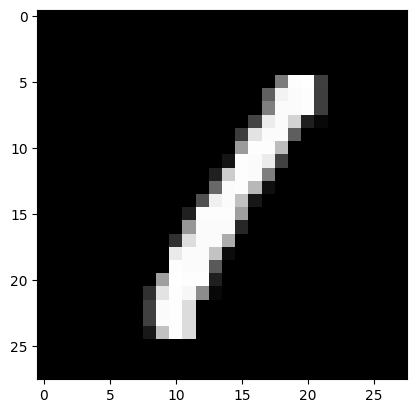

In [3]:
# Pick out the 4th (0-indexed) example from the training set
image, label = mnist_train[3]

# Plot the image
print("Default image shape: {}".format(image.shape))
image = image.reshape([28,28])
print("Reshaped image shape: {}".format(image.shape))
plt.imshow(image, cmap="gray")

# Print the label
print("The label for this image: {}".format(label))

## Shuffling the data
Once the dataset has been loaded, we are going to use DataLoader which is imported by
```python 
from torch.utils.data import DataLoader
```
Here we are loading the dataset in batches. This will help us with the program performance since we are not reading all the information at once. We also turned shuffle flag on
> shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).

See 
[Data Loader Documentation](!https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [4]:
train_loader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=False)

In [5]:
data_train_iter = iter(train_loader)
images, labels = next(data_train_iter)
print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


## The Logistic Regression Model

In [6]:
x = images.view(-1, 28*28)
print("The shape of input x: {}".format(x.shape))

The shape of input x: torch.Size([100, 784])


We inicialize the weigths and bias randomly

In [7]:
# Randomly initialize weights W
W = torch.randn(784, 10)/np.sqrt(784)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(10, requires_grad=True)

In [8]:
# Linear transformation with W and b
y = torch.matmul(x, W) + b
print(y[0,:])

tensor([-0.2068,  0.1047, -0.0199,  0.5373, -0.1939,  0.5420,  0.3384,  0.3090,
        -0.1919,  0.0504], grad_fn=<SliceBackward0>)


We applied the softmax function [see library](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) ![Softmax equation](https://i.ytimg.com/vi/lvNdl7yg4Pg/maxresdefault.jpg) 

In the second option we used the function described in the library

In [9]:
# Option 1: Softmax to probabilities from equation
py_eq = torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)
print("py[0] from equation: {}".format(py_eq[0]))

# Option 2: Softmax to probabilities with torch.nn.functional
import torch.nn.functional as F
py = F.softmax(y, dim=1)
print("py[0] with torch.nn.functional.softmax: {}".format(py[0]))

py[0] from equation: tensor([0.0689, 0.0941, 0.0831, 0.1450, 0.0698, 0.1457, 0.1189, 0.1154, 0.0699,
        0.0891], grad_fn=<SelectBackward0>)
py[0] with torch.nn.functional.softmax: tensor([0.0689, 0.0941, 0.0831, 0.1450, 0.0698, 0.1457, 0.1189, 0.1154, 0.0699,
        0.0891], grad_fn=<SelectBackward0>)


In [10]:
print(labels.shape)

torch.Size([100])


By caclulating the cross_entropy we will know how good is our model. [See documentation)](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy) ![](https://i.stack.imgur.com/gNip2.png)

In [11]:
# Cross-entropy loss from equation
cross_entropy_eq = torch.mean(-torch.log(py_eq)[range(labels.shape[0]),labels])
print("cross entropy from equation: {}".format(cross_entropy_eq))

# Option 2: cross-entropy loss with torch.nn.functional
cross_entropy = F.cross_entropy(y, labels)
print("cross entropy with torch.nn.functional.cross_entropy: {}".format(cross_entropy))

cross entropy from equation: 2.376065731048584
cross entropy with torch.nn.functional.cross_entropy: 2.376065731048584


Defining optimizer

> [torch.optim](https://pytorch.org/docs/stable/optim.html) is a package implementing various optimization algorithms. Most commonly used methods are already supported, and the interface is general enough, so that more sophisticated ones can be also easily integrated in the future.

To use torch.optim **you have to construct an optimizer object**, that will **hold** the current state and will **update** the parameters based on the computed gradients.

> [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) Implements stochastic gradient descent (optionally with momentum).

In [12]:
# Optimizer
optimizer = torch.optim.SGD([W,b], lr=0.1)

In [13]:
cross_entropy.backward()

In [14]:
b.grad

tensor([ 0.0401,  0.0032,  0.0026,  0.0193, -0.0409,  0.0435, -0.0123, -0.0352,
         0.0059, -0.0263])

All optimizers implement a step() method, that updates the parameters. [see](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step)

In [15]:
b

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [16]:
optimizer.step()

In [17]:
b

tensor([-0.0040, -0.0003, -0.0003, -0.0019,  0.0041, -0.0044,  0.0012,  0.0035,
        -0.0006,  0.0026], requires_grad=True)

One more thing to keep in mind though: gradients calculated by backward() don't override the old values; instead, they accumulate. Therefore, you'll want to clear the gradient buffers before you compute gradients for the next minibatch

In [18]:
print("b.grad before zero_grad(): {}".format(b.grad))
optimizer.zero_grad()
print("b.grad after zero_grad(): {}".format(b.grad))

b.grad before zero_grad(): tensor([ 0.0401,  0.0032,  0.0026,  0.0193, -0.0409,  0.0435, -0.0123, -0.0352,
         0.0059, -0.0263])
b.grad after zero_grad(): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


## Model training

In [19]:
# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28) #Reshape the image into a vector
    y = torch.matmul(x, W) + b #Forward propagation
    cross_entropy = F.cross_entropy(y, labels) #Evaluates how good/bad is the model
    # Backward pass
    cross_entropy.backward() #Makes the backpropagation
    optimizer.step()# Updates the values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 64.87it/s]


## Testing

We're going to wrap evaluation with `torch.no_grad()`, as we're not interested in computing gradients during evaluation. *By turning off the autograd engine, we can speed up evaluation.*

In [20]:
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = torch.matmul(x, W) + b
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.77it/s]

Test accuracy: 0.9049000144004822


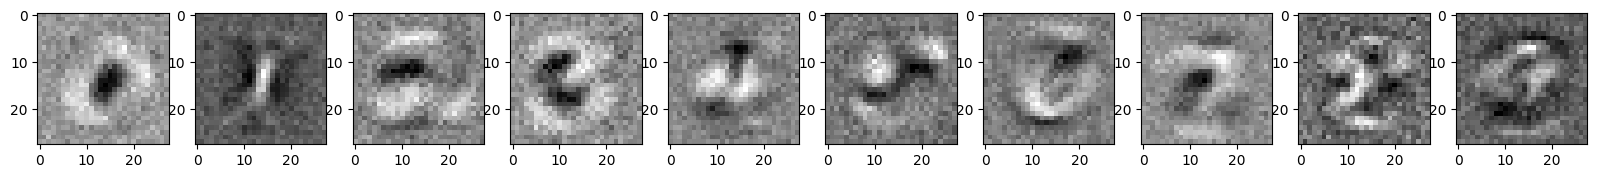

In [21]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

## Using Object Oriented factorization

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

# Load the data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

## Training
# Instantiate model
model = MNIST_Logistic_Regression()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Iterate through train set minibatchs 
for images, labels in tqdm(train_loader):
    # Zero out the gradients
    optimizer.zero_grad()
    
    # Forward pass
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    # Backward pass
    loss.backward()
    optimizer.step()

## Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 0.9017000198364258
